In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import binned_statistic

from models import CFM
from models import Classifier
from gaussian_toy import GaussianToy
from plots import plot_naive_unfold, plot_reweighted_distribution, plot_prior_unfold

Create Gaussian toy example. Define six datasets:
1. Reco-level simulation
2. Gen-level simulation
3. Background simulation
4. Reco-level data
5. Gen-level data
6. Background data

In [2]:
data_params = { "n_dim": 1,
                "n_mc": 1000000,
                "mc_mu": 0,
                "mc_sigma": 1,
                "n_data": 1000000,
                "data_mu": 0.2,
                "data_sigma": 0.8,
                "detector_mu": 0,
                "detector_sigma": 0.5,
                "n_background": 100000,
                "background_mu": 0,
                "background_sigma": 1.2,
                "mc_rec_cut": True,
                "mc_gen_cut": False,
                "data_rec_cut": True,
                "data_gen_cut":False ,
                "rec_cut_position": 1.2,
                "gen_cut_position":2.0
}

In [3]:
ToyModel = GaussianToy(data_params)

Define background subtraction classifier

In [4]:
bkg_true = torch.cat([ToyModel.data_rec[ToyModel.data_rec_mask.bool()], ToyModel.mc_background_rec[ToyModel.mc_background_mask.bool()]])
weights_true = torch.cat([torch.ones_like(ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()]), torch.ones_like( ToyModel.mc_background_rec[ToyModel.mc_background_mask.bool()][:,0]) * -1])
bkg_false = ToyModel.data_rec[ToyModel.data_rec_mask.bool()]
weights_false = torch.ones_like(bkg_false[:,0])

In [5]:
background_classifier_params = { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 1.e-4,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000
}

In [6]:
background_classifier = Classifier(1, background_classifier_params)

In [7]:
background_classifier.train_classifier(bkg_true, bkg_false, weights_true, weights_false)

Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.2648741006851196 after time 13.3
    Finished epoch 6 with average loss 1.2646968364715576 after time 97.0
    Finished epoch 12 with average loss 1.2647314071655273 after time 178.1
    Finished epoch 18 with average loss 1.264440655708313 after time 258.4
    Finished epoch 24 with average loss 1.2646901607513428 after time 338.6
    Finished epoch 29 with average loss 1.2644809484481812 after time 405.7


In [8]:
background_weights = background_classifier.evaluate(ToyModel.data_rec[ToyModel.data_rec_mask.bool()])
background_weights = background_weights * len(ToyModel.mc_rec[ToyModel.mc_rec_mask.bool()])/ background_weights.sum()

In [9]:
with PdfPages(f"Plots/background_suppression_cut_sb.pdf") as out:
    plot_reweighted_distribution(out, ToyModel.data_signal_rec[:,0][ToyModel.data_rec_mask[:-100000].bool()],
                                 ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()],
                                 ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()], reweighted_weights=background_weights,
                                 range=[-3,4], labels=[r"$\text{signal} |_r$" , "reweighted","data $(s+b)|_r$"], name="x_1")

/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:165: RuntimeWarning: invalid value encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:166: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((y_err / y) ** 2 + (hist_errors[0] / hists[0]) ** 2)


Train CFM unfolding network

In [10]:
iterative_unfolding_params = { "iterations" : 5,
                               "generator": { "hidden_layers": 4,
                                            "internal_size": 64,
                                            "lr": 1.e-4,
                                            "n_epochs" : 30,
                                            "batch_size" : 128,
                                            "batch_size_sample": 2000},
                               "classifier": {"hidden_layers": 4,
                                            "internal_size": 64,
                                            "lr": 1.e-4,
                                            "n_epochs" : 30,
                                            "batch_size" : 128,
                                            "batch_size_sample": 2000}}

Starting with the 0.iteration.
Initalize unfolder
Training CFM for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.7577389478683472 after time 9.3
    Finished epoch 6 with average loss 0.7040432691574097 after time 60.0
    Finished epoch 12 with average loss 0.7041594386100769 after time 111.0
    Finished epoch 18 with average loss 0.7040480971336365 after time 162.8
    Finished epoch 24 with average loss 0.702921986579895 after time 214.0
    Finished epoch 29 with average loss 0.7033243179321289 after time 256.1
unfold data


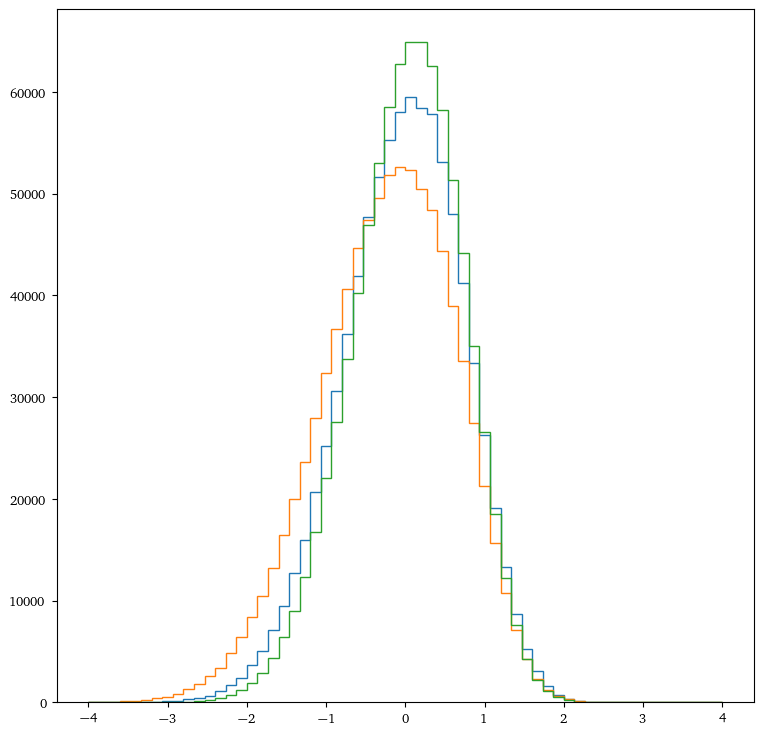

Starting with the 1.iteration.
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.3079546689987183 after time 12.1
    Finished epoch 6 with average loss 1.3075227737426758 after time 85.7
    Finished epoch 12 with average loss 1.3074874877929688 after time 159.4
    Finished epoch 18 with average loss 1.307530403137207 after time 233.2
    Finished epoch 24 with average loss 1.3074820041656494 after time 307.0
    Finished epoch 29 with average loss 1.3075166940689087 after time 368.6
Training CFM for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.6279428005218506 after time 8.6
    Finished epoch 6 with average loss 0.6268942952156067 after time 60.0
    Finished epoch 12 with average loss 0.627469003200531 after time 110.8
    Finished epoch 18 with average loss 0.6294072866439819 after time 161.4
    Finished epoch 24 with average loss 0.6291050910949707 after time 212.2
    Finished epoch 29 with average loss 0.62768816947

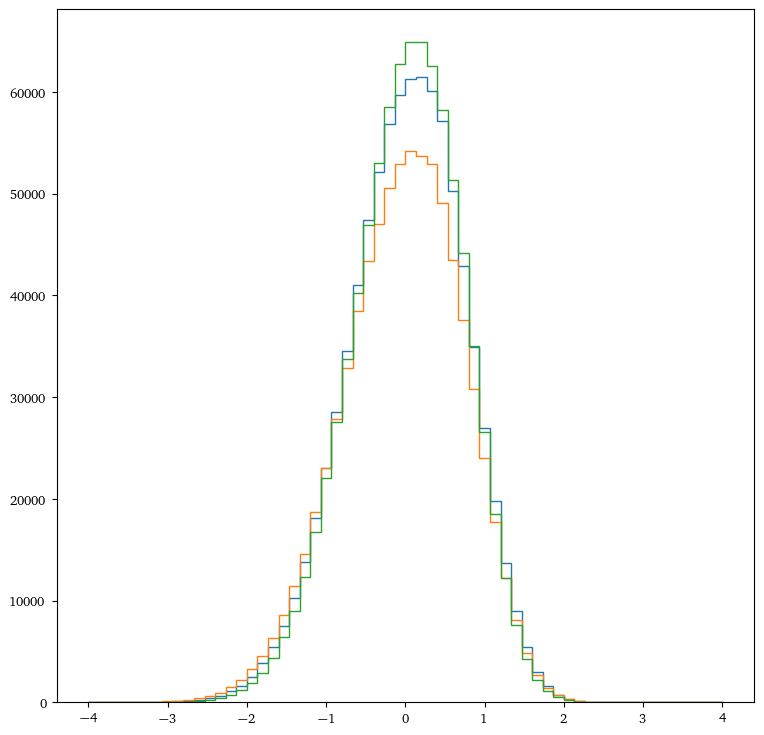

Starting with the 2.iteration.
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.2648171186447144 after time 12.2
    Finished epoch 6 with average loss 1.2647755146026611 after time 86.0
    Finished epoch 12 with average loss 1.2647689580917358 after time 160.2
    Finished epoch 18 with average loss 1.2647424936294556 after time 234.3
    Finished epoch 24 with average loss 1.2647619247436523 after time 308.3
    Finished epoch 29 with average loss 1.2647677659988403 after time 370.0
Training CFM for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.6187677979469299 after time 8.7
    Finished epoch 6 with average loss 0.6198001503944397 after time 60.8
    Finished epoch 12 with average loss 0.6190531253814697 after time 111.8
    Finished epoch 18 with average loss 0.6177578568458557 after time 162.8
    Finished epoch 24 with average loss 0.6193395853042603 after time 213.8
    Finished epoch 29 with average loss 0.619382917

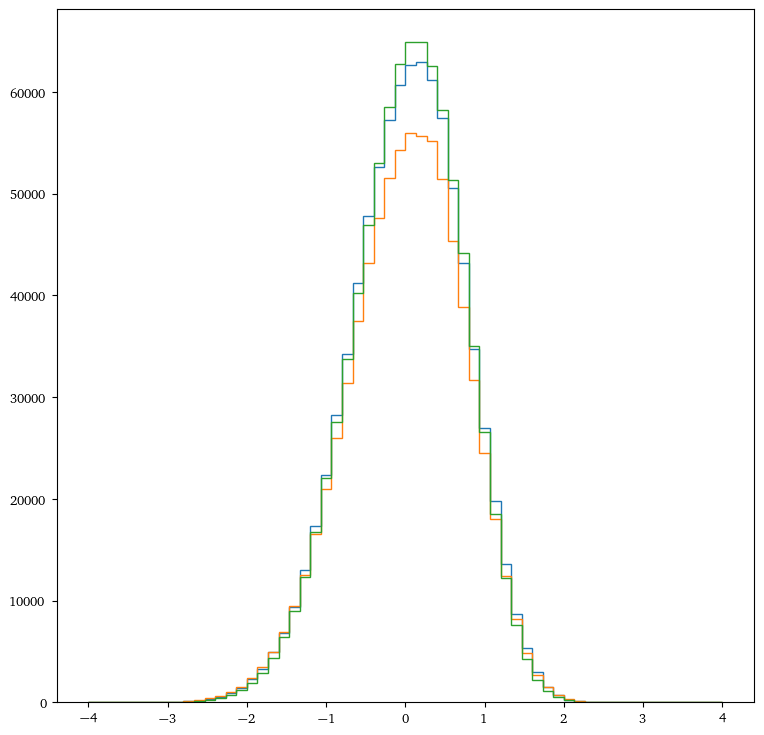

Starting with the 3.iteration.
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.2632864713668823 after time 12.4
    Finished epoch 6 with average loss 1.2632590532302856 after time 86.7
    Finished epoch 12 with average loss 1.2632619142532349 after time 160.7
    Finished epoch 18 with average loss 1.2632638216018677 after time 234.7
    Finished epoch 24 with average loss 1.2632548809051514 after time 308.7
    Finished epoch 29 with average loss 1.2632553577423096 after time 370.3
Training CFM for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.6176666021347046 after time 8.7
    Finished epoch 6 with average loss 0.6172056198120117 after time 59.6
    Finished epoch 12 with average loss 0.619604229927063 after time 110.7
    Finished epoch 18 with average loss 0.6176249980926514 after time 161.6
    Finished epoch 24 with average loss 0.6182289123535156 after time 212.5
    Finished epoch 29 with average loss 0.6184885501

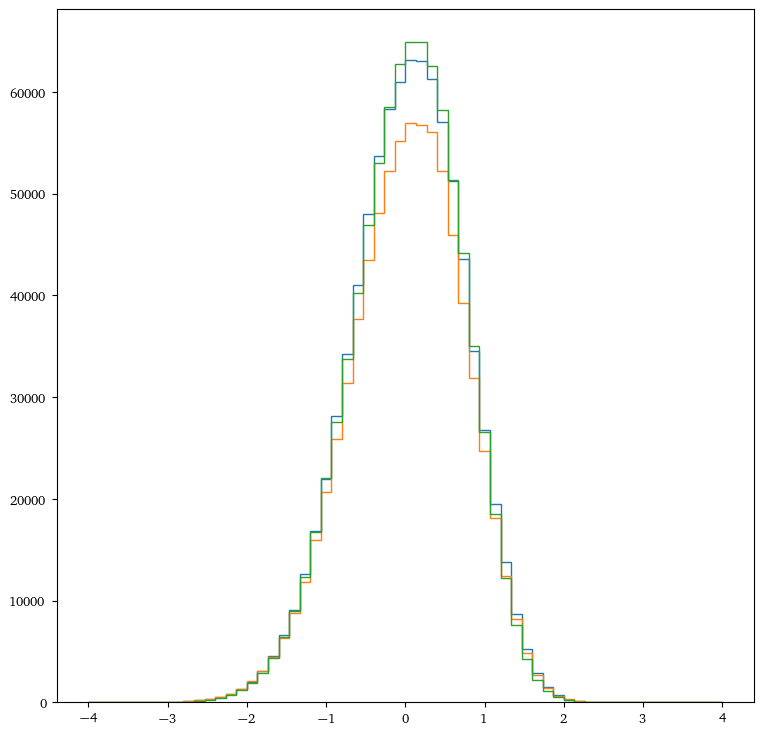

Starting with the 4.iteration.
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.2653577327728271 after time 12.1
    Finished epoch 6 with average loss 1.2653279304504395 after time 85.1
    Finished epoch 12 with average loss 1.2653554677963257 after time 158.7
    Finished epoch 18 with average loss 1.2653526067733765 after time 232.5
    Finished epoch 24 with average loss 1.2653380632400513 after time 306.2
    Finished epoch 29 with average loss 1.2653433084487915 after time 367.4
Training CFM for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.6165673732757568 after time 8.7
    Finished epoch 6 with average loss 0.6160866618156433 after time 60.0
    Finished epoch 12 with average loss 0.6158156394958496 after time 110.9
    Finished epoch 18 with average loss 0.615369439125061 after time 161.7
    Finished epoch 24 with average loss 0.613357663154602 after time 212.5
    Finished epoch 29 with average loss 0.61548894643

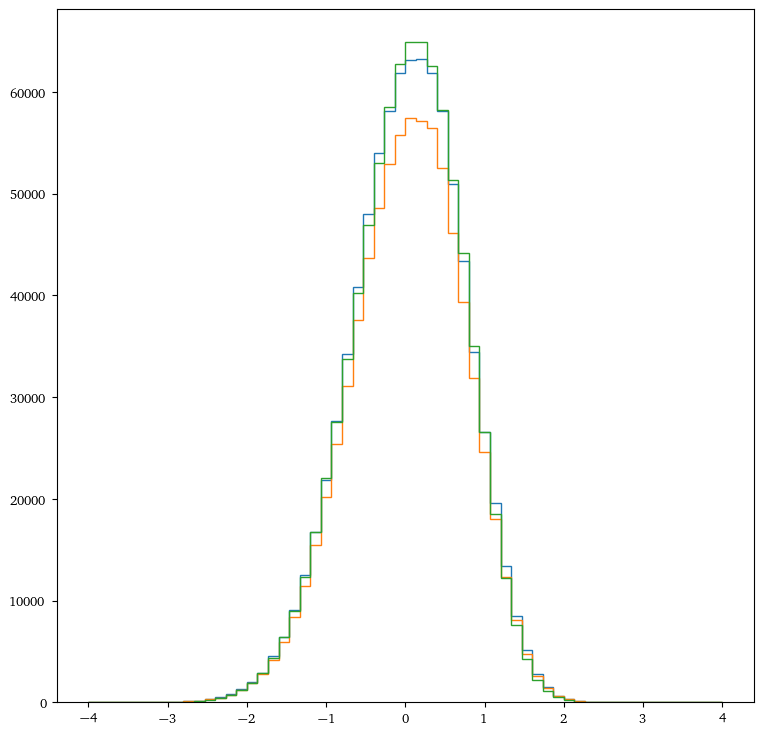

In [11]:
for i in range(iterative_unfolding_params["iterations"]):
    print(f"Starting with the {i}.iteration.")
    if i == 0:
        print("Initalize unfolder")
        unfolder = CFM(1, 1, iterative_unfolding_params["generator"])
        mc_gen = ToyModel.mc_gen[(ToyModel.mc_rec_mask.bool())]
        mc_rec = ToyModel.mc_rec[(ToyModel.mc_rec_mask.bool())]
        mc_weights = torch.ones_like(mc_rec[:, 0])
        data_weights = background_weights
    if i > 0 :
        iterative_classifier = Classifier(1, iterative_unfolding_params["classifier"])
        iterative_classifier.train_classifier(data_unfold, mc_gen, data_weights, mc_weights)
        mc_weights *= iterative_classifier.evaluate(mc_gen)
    unfolder.train_unfolder(mc_gen, mc_rec, mc_weights)
    print("unfold data")
    data_unfold = unfolder.evaluate(ToyModel.data_rec[ToyModel.data_rec_mask.bool()])
    fig, axes = plt.subplots()
    axes.hist(data_unfold[:,0], weights=data_weights, bins=60, histtype="step", range=[-4,4])
    axes.hist(mc_gen[:,0], weights=mc_weights, bins=60, histtype='step', range=[-4,4])
    axes.hist(ToyModel.data_gen[:,0][(ToyModel.data_rec_mask[:-100000].bool())], bins=60, range=[-4,4], histtype="step")
    plt.show()

In [12]:
with PdfPages(f"Plots/prior_dependence_cuts_sb.pdf") as out:
    plot_prior_unfold(out, ToyModel.data_gen[:,0][(ToyModel.data_rec_mask[:-100000].bool())],ToyModel.mc_gen[:,0][(ToyModel.mc_rec_mask.bool())],
                                 data_unfold[:, 0],
                      unfolded_weights=background_weights,
                                 range=[-3,4], name="x_1")

/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:272: RuntimeWarning: invalid value encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:273: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((y_err / y) ** 2 + (hist_errors[0] / hists[0]) ** 2)
/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:272: RuntimeWarning: divide by zero encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])


Train efficiency classifier

In [13]:
efficiency_classifier_params = { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 1.e-4,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000
}

In [14]:
efficiency_true = ToyModel.mc_gen[(ToyModel.mc_rec_mask.bool()) ]
efficiency_false = ToyModel.mc_gen[~(ToyModel.mc_rec_mask.bool()) ]

In [15]:
efficiency_classifier = Classifier(1, efficiency_classifier_params)

In [16]:
efficiency_classifier.train_classifier(efficiency_true, efficiency_false, balanced=False)

    Training with unbalanced training set with weight 6.043840865547166
Training classifier for 180 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.728344202041626 after time 2.4
    Finished epoch 36 with average loss 1.2908825874328613 after time 77.2
    Finished epoch 72 with average loss 1.279802918434143 after time 150.9
    Finished epoch 108 with average loss 1.2866239547729492 after time 224.7
    Finished epoch 144 with average loss 1.287140965461731 after time 298.5
    Finished epoch 179 with average loss 1.2812615633010864 after time 370.2


In [17]:
efficiency = efficiency_classifier.evaluate(data_unfold, return_weights=False)

In [18]:
data_weights =background_weights/ efficiency

In [24]:
ToyModel.data_gen_mask = ~((ToyModel.data_gen > 1.2).squeeze())
unfolded_mask = ~((data_unfold > 1.2).squeeze())

In [22]:
with PdfPages(f"Plots/efficiency_effects_cut_sb.pdf") as out:
    plot_reweighted_distribution(out, ToyModel.data_gen[:,0][(ToyModel.data_gen_mask.bool())],
                                 data_unfold[:,0],
                                 data_unfold[:,0],
                                 reweighted_weights=background_weights/efficiency,
                                 fake_weights=background_weights,
                                 range=[-3,4], labels=[r"$\text{gen}|_g$" , r"$\text{unfolded} / \delta$","unfolded"], name="x_1")

NameError: name 'efficiency' is not defined

In [28]:
with PdfPages(f"Plots/final_unfolding_cut_sb.pdf") as out:
    plot_naive_unfold(out, ToyModel.data_gen[:, 0][ToyModel.data_gen_mask.bool()],
                       ToyModel.data_rec[ (ToyModel.data_rec_mask.bool())][:, 0],
                      data_unfold[:, 0][unfolded_mask],
                        unfolded_weights=data_weights[unfolded_mask],
                      range=[-3, 4], name="x_1")

/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:56: RuntimeWarning: invalid value encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:57: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((y_err / y) ** 2 + (hist_errors[0] / hists[0]) ** 2)
